In [42]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quantstats as qs

colour_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from Trader import TradingEngine

# Data gathering

In [8]:
start = '2024-01-01'
end = '2025-07-01'

In [9]:
# WTI crude oil futures data
crude_df = yf.download('BZ=F', start=start, end=end, interval='1h')
crude_df.columns = [f"{price}" for price, _ in crude_df.columns]

C:\Users\Owen\AppData\Local\Temp\ipykernel_7796\1507294262.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  crude_df = yf.download('BZ=F', start=start, end=end, interval='1h')
[*********************100%***********************]  1 of 1 completed


In [10]:
# Heating oil futures data
heating_df = yf.download('HO=F', start=start, end=end, interval='1h')
heating_df.columns = [f"{price}" for price, _ in heating_df.columns]

C:\Users\Owen\AppData\Local\Temp\ipykernel_7796\537194432.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  heating_df = yf.download('HO=F', start=start, end=end, interval='1h')
[*********************100%***********************]  1 of 1 completed


In [11]:
df = pd.DataFrame({
    'crude_price': crude_df['Close'],
    'heating_price': heating_df['Close']
}).dropna()

# Construct a spread which consists of long one WTI crude future and short one heating oil future
df['spread'] = -df.crude_price + df.heating_price

In [12]:
# Construct moving averages upon which our strategy will be based
n_stds = 2
rolling_window = 1000
df['spread_ma'] = df.spread.rolling(window=rolling_window).mean()
df['spread_ub'] = df.spread_ma + df.spread.rolling(window=rolling_window).std() * n_stds
df['spread_lb'] = df.spread_ma - df.spread.rolling(window=rolling_window).std() * n_stds

# Some plots

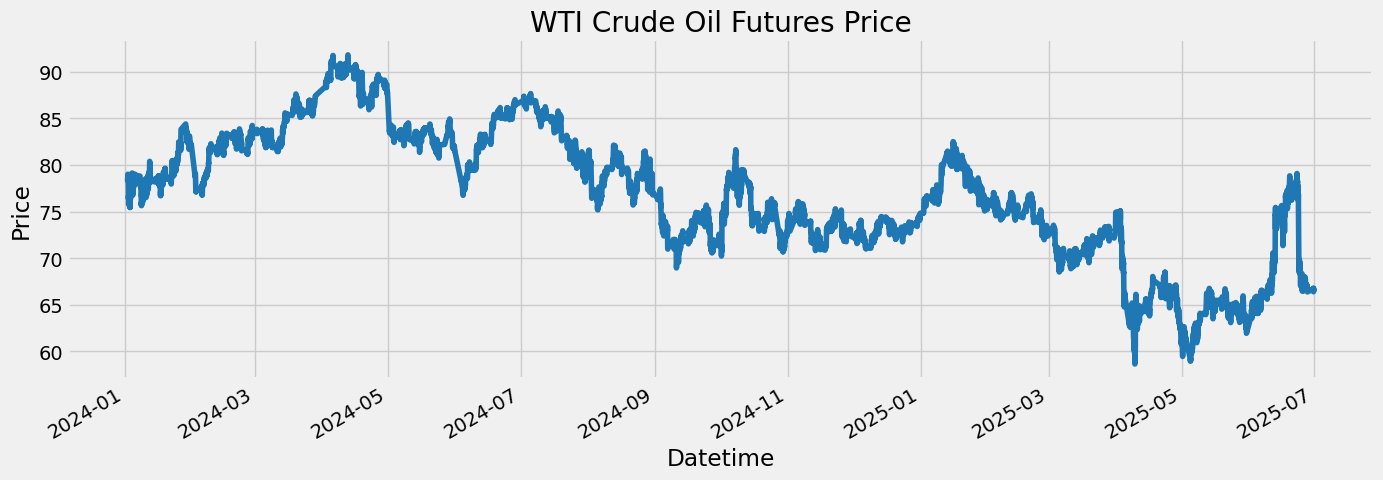

In [14]:
df.crude_price.plot(style='-', 
              figsize=(15,5), 
              color=colour_pal[0], 
              title='WTI Crude Oil Futures Price', 
              ylabel='Price')
plt.show()

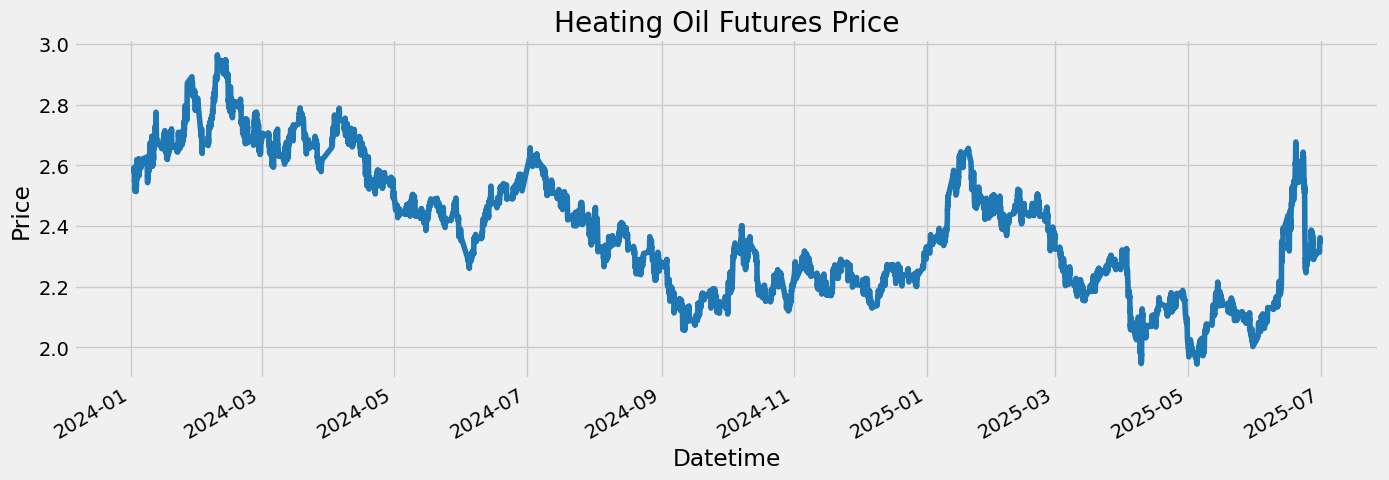

In [15]:
df.heating_price.plot(style='-', 
              figsize=(15,5), 
              color=colour_pal[0], 
              title='Heating Oil Futures Price', 
              ylabel='Price')
plt.show()

In [16]:
df.heating_price.corr(df.crude_price)

0.8270010018286034

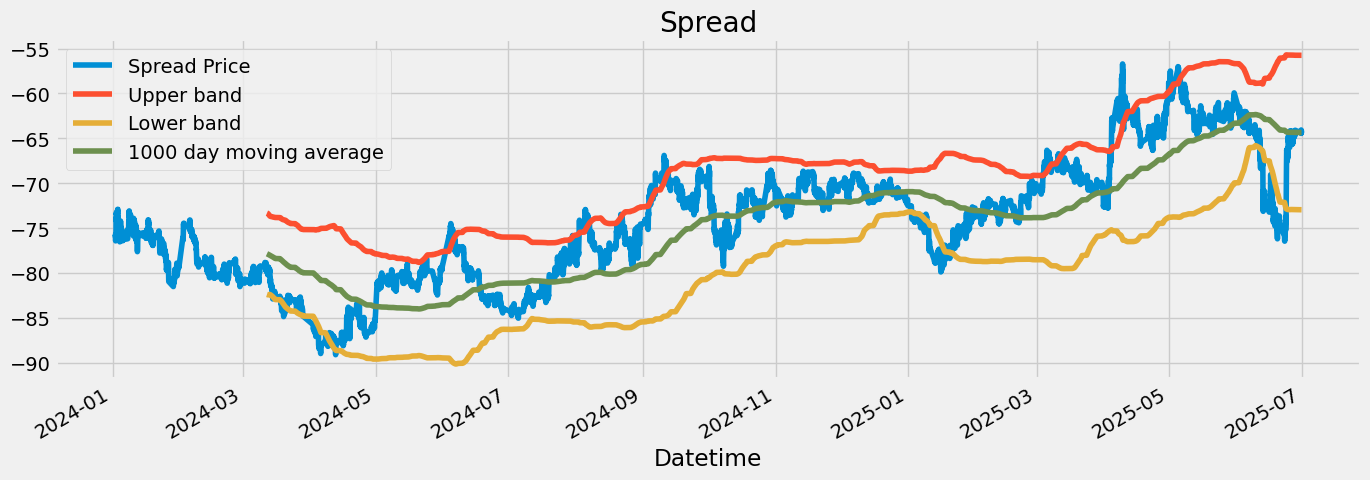

In [17]:
fig, ax = plt.subplots(figsize=(15,5))
df.spread.plot(ax=ax, label='Spread Price', title='Spread')
df.spread_ub.plot(ax=ax, label='Upper band')
df.spread_lb.plot(ax=ax, label='Lower band')
df.spread_ma.plot(ax=ax, label=f'{rolling_window} day moving average')
ax.legend()
plt.show()

# Implement strategy

In [19]:
# Generate buy and sell signals
df['buy_signal'] = (df.spread < df.spread_lb).astype(int)
df['sell_signal'] = -(df.spread > df.spread_ub).astype(int)

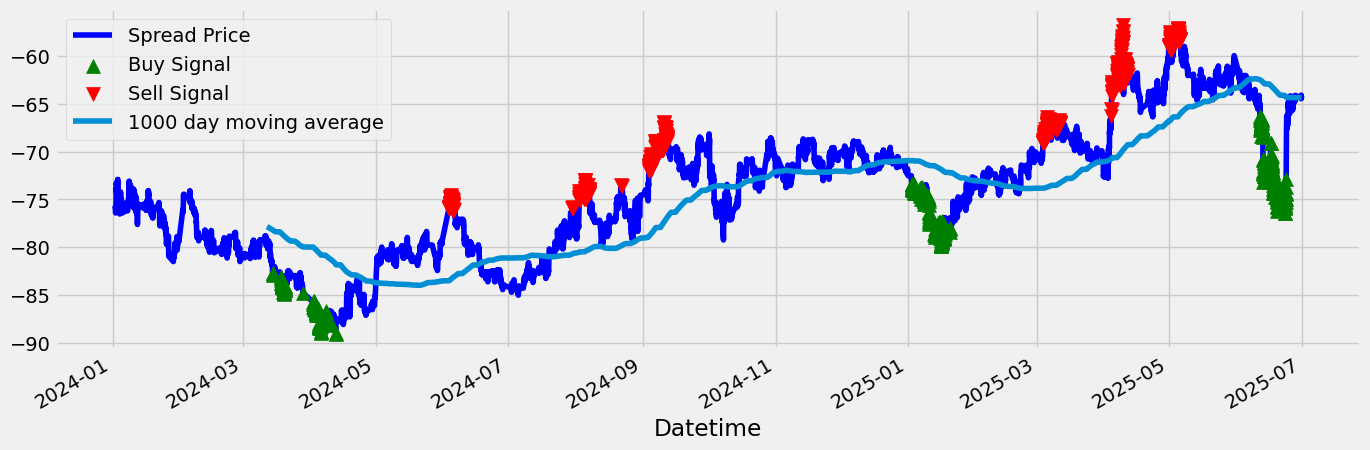

In [20]:
# Plot buy and sell signals to see where strategy wins/loses

buy_mask = df.buy_signal > 0
sell_mask = df.sell_signal < 0

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df.index, df['spread'], label='Spread Price', color='blue')
ax.scatter(df.index[buy_mask], df['spread'][buy_mask],
            label='Buy Signal', marker='^', color='green', s=100, zorder=3)
ax.scatter(df.index[sell_mask], df['spread'][sell_mask],
            label='Sell Signal', marker='v', color='red', s=100, zorder=3)
df.spread_ma.plot(ax=ax, label=f'{rolling_window} day moving average')
ax.legend()
plt.show()

In [57]:
trader = TradingEngine(balance=1000)

In [59]:
returns = trader.run_strategy(np.array(df.buy_signal), np.array(df.sell_signal), np.array(df.spread), 
                    np.array(df.spread_ma), df.index, allow_negative_balance=False)

# Performance evaluation

In [62]:
print(f'Final balance: {trader.balance:.2f}')
print(f'Net position: {trader.position}')
print(f'Number of trades: {trader.trade_count}')

Final balance: 1882.90
Net position: 0
Number of trades: 199


In [64]:
trade_log = trader.get_trade_log()
trade_log.head()

,date,action,price,quantity,position,balance
0,2024-03-14 14:00:00+00:00,BUY,-82.661303,1,1,1082.661303
1,2024-03-14 16:00:00+00:00,BUY,-82.879596,1,2,1165.540899
2,2024-03-14 17:00:00+00:00,BUY,-82.738297,1,3,1248.279196
3,2024-03-18 07:00:00+00:00,BUY,-83.101401,1,4,1331.380597
4,2024-03-18 09:00:00+00:00,BUY,-83.405100,1,5,1414.785697


                           Strategy
-------------------------  ----------
Start Period               2024-01-02
End Period                 2024-06-04
Risk-Free Rate             0.0%
Time in Market             32.0%

Cumulative Return          89.1%
CAGR﹪                     183.64%

Sharpe                     0.37
Prob. Sharpe Ratio         87.87%
Smart Sharpe               0.35
Sortino                    0.64
Smart Sortino              0.61
Sortino/√2                 0.45
Smart Sortino/√2           0.43
Omega                      1.18

Max Drawdown               -51.55%
Max DD Date                2024-04-12
Max DD Period Start        2024-03-21
Max DD Period End          2024-04-17
Longest DD Days            27
Volatility (ann.)          40.16%
Calmar                     3.56
Skew                       6.92
Kurtosis                   189.38

Expected Daily %           0.03%
Expected Monthly %         11.2%
Expected Yearly %          89.1%
Kelly Criterion            7.29%
Risk of Ruin 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2024-03-21,2024-04-12,2024-04-17,27,-51.546892,-42.369766
2,2024-04-22,2024-04-26,2024-04-30,9,-42.719873,-41.012185
3,2024-04-18,2024-04-19,2024-04-22,4,-42.162066,-40.422054
4,2024-03-20,2024-03-21,2024-03-21,1,-4.211714,-3.805039
5,2024-04-17,2024-04-18,2024-04-18,1,-3.708285,-2.952274


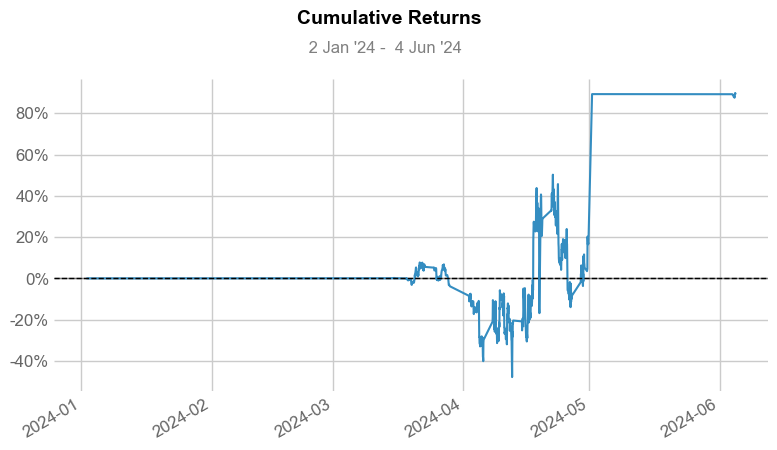

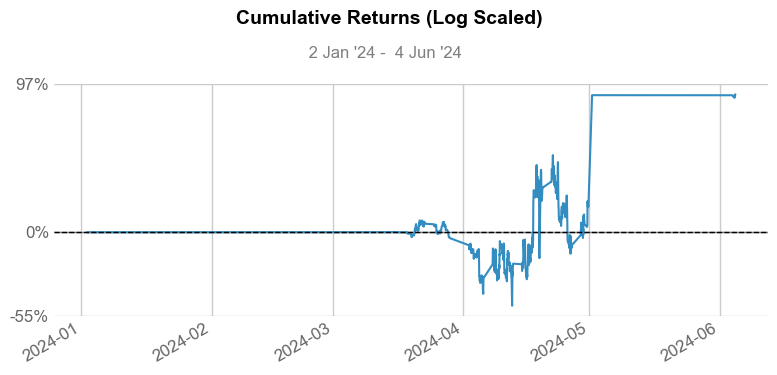

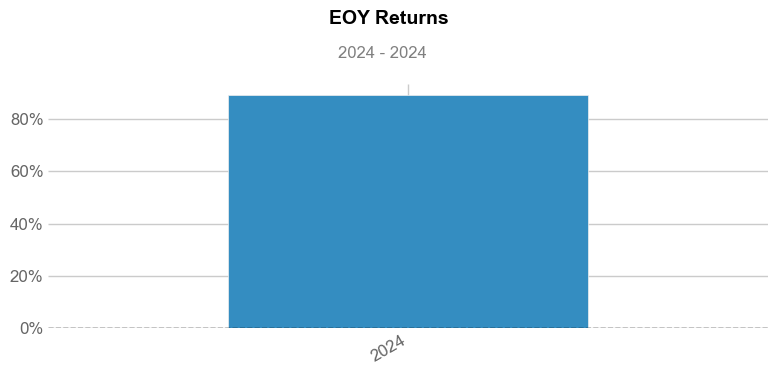

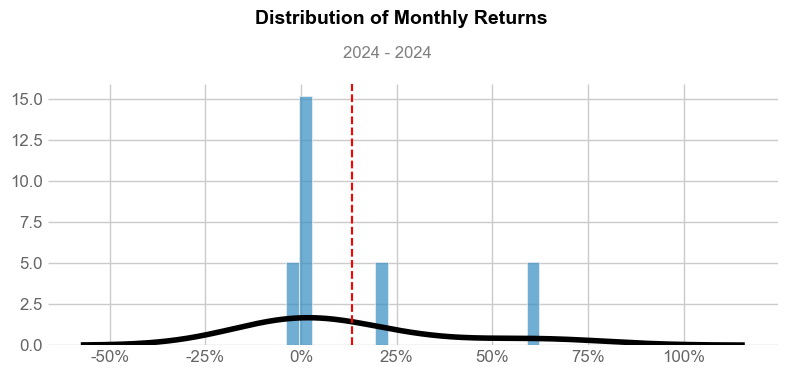

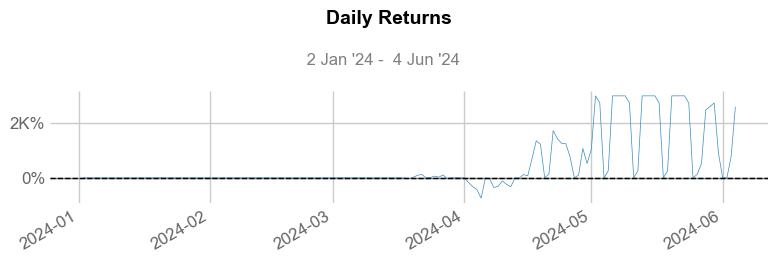

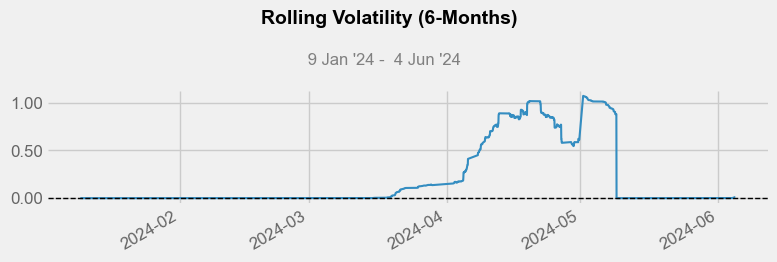

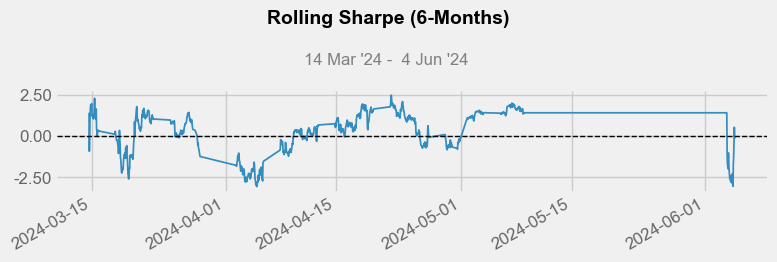

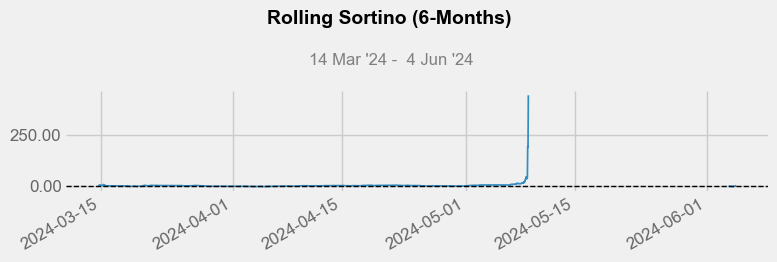

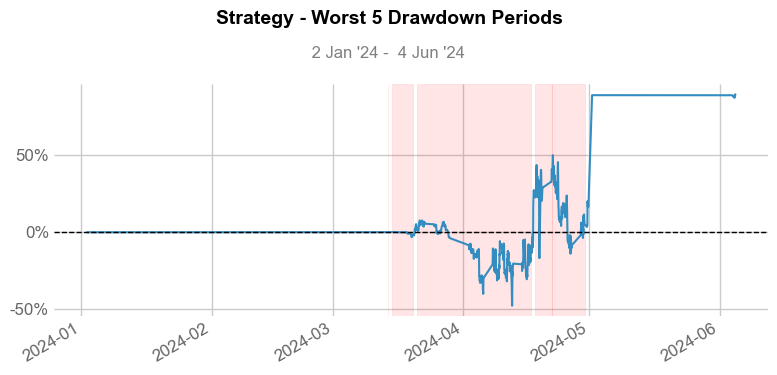

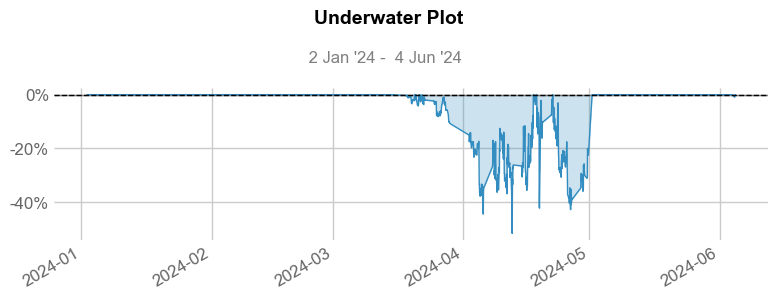

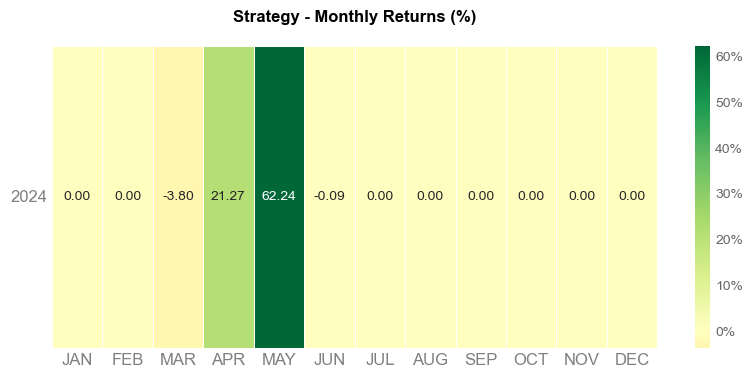

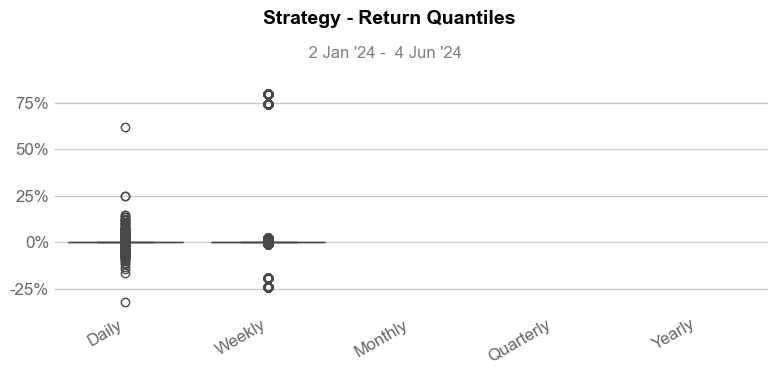

In [66]:
#qs.reports.html(returns)
qs.reports.full(returns)